In [1]:
import os, json, io
import numpy as np
import pandas as pd
# from models.load import TrainedModels

from utils.eval import save_iou_results
from utils.engine import get_iou_types, evaluate
from models.load import get_trained_model
from utils.eval import get_ap_ar, get_num_fps, get_num_fns, get_num_tps
from utils.print import print_title
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.paths import MIMIC_EYE_PATH
from tqdm import tqdm
from utils.train import  get_coco_eval_params
from utils.coco_eval import get_eval_params_dict
from data.strs import SourceStrs, TaskStrs
from IPython.display import clear_output
from coco_froc_analysis.froc.froc_curve import get_froc_curve, get_interpolate_froc

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# import itertools
# from scipy import interpolate
# from coco_froc_analysis.froc.froc_curve import generate_froc_curve

# def get_froc_curve(dataset, dts, eval_gts, plot_title=None, use_iou=True, n_sample_points=100, froc_save_folder="./froc_figures"):
#     anns = []
#     gts = [
#         g["lesion-detection"]
#         for g in list(itertools.chain.from_iterable(list(eval_gts)))
#     ]
#     for g in gts:
#         for i, bb in enumerate(g["unsized_boxes"]):
#             anns.append(
#                 {
#                     "image_id": g["image_id"].item(),
#                     "category_id": g["labels"][i].item(),
#                     "iscrowd": g["iscrowd"][i].item(),
#                     "bbox": bb.tolist(),
#                     "ignore": 0,
#                 }
#             )

#     pr = []
#     for dt in dts:
#         for image_id, d in dt.items():
#             for i in range(len(d["boxes"])):
#                 pr.append(
#                     {
#                         "image_id": image_id,
#                         "category_id": d["labels"][i].item(),
#                         "score": d["scores"][i].item(),
#                         "bbox": d["boxes"][i].numpy().tolist(),
#                     }
#                 )

#     categories = [
#         {
#             "id": dataset.disease_to_idx(i),
#             "name": i,
#             "color": "blue",
#         }
#         for i in dataset.labels_cols
#     ]

#     gt = {
#         "categories": categories,
#         "annotations": anns,
#         "images": [{"id": id} for id in list(set([g["image_id"].item() for g in gts]))],
#     }
    
#     os.makedirs(froc_save_folder, exist_ok=True)

#     stats, lls_accuracy, nlls_per_image = generate_froc_curve(
#         gt=gt,
#         pr=pr,
#         use_iou=use_iou,
#         iou_thres=0.5,
#         n_sample_points=n_sample_points,
#         plot_title=plot_title,
#         plot_output_path= os.path.join(froc_save_folder, f"{plot_title}.png"),
#         bounds=None,
#     )

#     return stats, lls_accuracy, nlls_per_image


In [3]:
# def get_interpolate_froc(
#     stats, lls_accuracy,nlls_per_image, cat_id=None, fps_per_img=[0.5, 1, 2, 4], weight=True,
# ):
    
#     if cat_id is None:
#         number_all_lesions =sum([stats[cat_id]['n_lesions'] for cat_id in stats.keys()])
#         all_frocs = []
#         for cat_id in stats.keys():
#             f = interpolate.interp1d(
#                 nlls_per_image[cat_id], lls_accuracy[cat_id], fill_value="extrapolate"
#             )

#             cat_froc = f(fps_per_img)


#             if weight:
#                 cat_froc = cat_froc * ( stats[cat_id]["n_lesions"] /number_all_lesions) 

#             all_frocs.append(cat_froc)

#         if weight:
#             return np.array(all_frocs).sum(axis=0)
        
#         else:
#             return np.array(all_frocs).mean(axis=0)

#     else:
#         f = interpolate.interp1d(
#             nlls_per_image[cat_id], lls_accuracy[cat_id], fill_value="extrapolate"
#         )
#         return f(fps_per_img)


In [4]:
from enum import Enum

class TrainedModels(Enum):
    mobilenet_baseline = "val_lesion-detection_ap_0_1655_test_lesion-detection_ap_0_1648_epoch50_03-15-2023 16-43-54_lesion_dsetection_baseline_mobilenet"  # mobilenet baseline
    mobilenet_with_fix = "val_lesion-detection_ap_0_1918_test_lesion-detection_ap_0_1903_epoch16_03-16-2023 11-34-10_lesion_dsetection_with_fixation_mobilenet"
    resnet18_baseline = "val_lesion-detection_ap_0_1973_test_lesion-detection_ap_0_2010_epoch22_03-16-2023 19-44-55_lesion_dsetection_baseline_resnet"
    resnet18_with_fix = "val_lesion-detection_ap_0_1951_test_lesion-detection_ap_0_2195_epoch12_03-17-2023 00-31-54_lesion_dsetection_with_fixation_resnet"
    densenet161_baseline = "val_lesion-detection_ap_0_1990_test_lesion-detection_ap_0_2085_epoch5_03-17-2023 08-53-33_lesion_dsetection_baseline_densenet161"
    densenet161_with_fix = "val_lesion-detection_ap_0_2120_test_lesion-detection_ap_0_2104_epoch12_03-17-2023 18-36-01_lesion_dsetection_with_fixation_densenet161"
    efficientnet_b5_baseline = "val_lesion-detection_ap_0_1898_test_lesion-detection_ap_0_2055_epoch5_03-17-2023 23-30-57_lesion_dsetection_baseline_efficientnet_b5"
    efficientnet_b5_with_fix = "val_lesion-detection_ap_0_2117_test_lesion-detection_ap_0_2190_epoch8_03-18-2023 12-29-20_lesion_dsetection_with_fixation_efficientnet_b5"
    efficientnet_b0_baseline = "val_lesion-detection_ap_0_1934_test_lesion-detection_ap_0_1858_epoch10_03-18-2023 23-50-47_lesion_dsetection_baseline_efficientnet_b0"
    efficientnet_b0_with_fix = "val_lesion-detection_ap_0_2191_test_lesion-detection_ap_0_2162_epoch10_03-18-2023 19-38-11_lesion_dsetection_with_fixation_efficientnet_b0"
    convnext_base_with_fix = "val_lesion-detection_ap_0_2472_test_lesion-detection_ap_0_2637_epoch15_03-23-2023 20-20-07_lesion_dsetection_with_fixation_convnext_base_silent_report"
    # convnext_base_with_fix = "val_lesion-detection_ap_0_2610_test_lesion-detection_ap_0_2548_epoch22_03-22-2023 02-55-37_lesion_dsetection_with_fixation_convnext_base"
    convnext_base_baseline = "val_lesion-detection_ap_0_2426_test_lesion-detection_ap_0_2325_epoch20_03-22-2023 11-53-53_lesion_dsetection_baseline_convnext_base"
    convnext_base_with_fix_silent = "val_lesion-detection_ap_0_2405_test_lesion-detection_ap_0_2543_epoch19_03-24-2023 13-57-29_lesion_dsetection_with_fixation_convnext_base_silent_report"
    convnext_base_with_fix_full = "val_lesion-detection_ap_0_2602_test_lesion-detection_ap_0_2499_epoch22_03-24-2023 04-42-21_lesion_dsetection_with_fixation_convnext_base_full_report"
    vgg16_with_fix = "val_lesion-detection_ap_0_2301_test_lesion-detection_ap_0_2186_epoch22_03-20-2023 19-26-02_lesion_dsetection_with_fixation_vgg16"
    vgg16_baseline = "val_lesion-detection_ap_0_2113_test_lesion-detection_ap_0_2068_epoch12_03-21-2023 00-45-24_lesion_dsetection_baseline_vgg16"
    regnet_y_8gf_with_fix = "val_lesion-detection_ap_0_2267_test_lesion-detection_ap_0_2029_epoch12_03-21-2023 11-28-48_lesion_dsetection_with_fixation_regnet_y_8gf"
    regnet_y_8gf_baseline = "val_lesion-detection_ap_0_1883_test_lesion-detection_ap_0_1658_epoch13_03-21-2023 15-22-32_lesion_dsetection_baseline_regnet_y_8gf"

In [5]:
naming_map = {
    TrainedModels.mobilenet_baseline: "mobilenet_baseline",
    TrainedModels.mobilenet_with_fix: "mobilenet_with_fix",
    TrainedModels.resnet18_baseline: "resnet18_baseline",
    TrainedModels.resnet18_with_fix: "resnet18_with_fix",
    TrainedModels.densenet161_baseline: "densenet161_baseline",
    TrainedModels.densenet161_with_fix: "densenet161_with_fix",
    TrainedModels.efficientnet_b5_baseline: "efficientnet_b5_baseline",
    TrainedModels.efficientnet_b5_with_fix: "efficientnet_b5_with_fix",
    TrainedModels.efficientnet_b0_baseline: "efficientnet_b0_baseline",
    TrainedModels.efficientnet_b0_with_fix: "efficientnet_b0_with_fix",
    TrainedModels.convnext_base_with_fix: "convnext_base_with_fix",
    TrainedModels.convnext_base_baseline: "convnext_base_baseline",
    TrainedModels.convnext_base_with_fix_silent: "convnext_base_with_fix_silent",
    TrainedModels.convnext_base_with_fix_full:"convnext_base_with_fix_full",
    TrainedModels.vgg16_with_fix: "vgg16_with_fix",
    TrainedModels.vgg16_baseline: "vgg16_baseline",
    TrainedModels.regnet_y_8gf_with_fix: "regnet_y_8gf_with_fix",
    TrainedModels.regnet_y_8gf_baseline: "regnet_y_8gf_baseline",
}


In [6]:
normal_iou_thrs = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
score_thresholds = [0.05]

This notebook will running on device: [CUDA]
Using pretrained backbone. convnext_base
Using pretrained backbone. convnext_base
Using SGD as optimizer with lr=0.01
creating index...
index created!
Evaluation:  [ 0/57]  eta: 0:03:04  loss: 0.2616 (0.2616)  lesion-detection_performer-object_detection_loss_classifier: 0.1265 (0.1265)  lesion-detection_performer-object_detection_loss_box_reg: 0.0874 (0.0874)  lesion-detection_performer-object_detection_loss_objectness: 0.0410 (0.0410)  lesion-detection_performer-object_detection_loss_rpn_box_reg: 0.0067 (0.0067)  model_time: 1680254336.0000 (1680254345.3831)  evaluator_time: 0.0000 (0.0000)  time: 3.2310  data: 1.9049  max mem: 2756
Evaluation:  [56/57]  eta: 0:00:02  loss: 0.1972 (0.1931)  lesion-detection_performer-object_detection_loss_classifier: 0.1017 (0.1022)  lesion-detection_performer-object_detection_loss_box_reg: 0.0751 (0.0710)  lesion-detection_performer-object_detection_loss_objectness: 0.0165 (0.0167)  lesion-detection_perfor

  0%|          | 0/200 [00:00<?, ?it/s]

Evaluation:  [ 0/57]  eta: 0:02:20  loss: 0.2216 (0.2216)  lesion-detection_performer-object_detection_loss_classifier: 0.1095 (0.1095)  lesion-detection_performer-object_detection_loss_box_reg: 0.0904 (0.0904)  lesion-detection_performer-object_detection_loss_objectness: 0.0177 (0.0177)  lesion-detection_performer-object_detection_loss_rpn_box_reg: 0.0039 (0.0039)  model_time: 1680254464.0000 (1680254472.7942)  evaluator_time: 0.0000 (0.0000)  time: 2.4690  data: 2.0275  max mem: 2756
Evaluation:  [56/57]  eta: 0:00:02  loss: 0.1777 (0.1933)  lesion-detection_performer-object_detection_loss_classifier: 0.0959 (0.1022)  lesion-detection_performer-object_detection_loss_box_reg: 0.0661 (0.0711)  lesion-detection_performer-object_detection_loss_objectness: 0.0116 (0.0169)  lesion-detection_performer-object_detection_loss_rpn_box_reg: 0.0022 (0.0031)  model_time: 1680254592.0000 (1680254533.2404)  evaluator_time: 0.0000 (0.0000)  time: 2.2587  data: 1.9732  max mem: 2756
Evaluation: Total 

100%|██████████| 1/1 [24:18<00:00, 1458.40s/it]

   num_fps  num_fns  num_tps  \
0      513      246      158   

                                         coco_states  \
0  [{"ap": 1, "iouThr": null, "areaRng": "all", "...   

   Sensitivity@ [avgFP=0.5]  Sensitivity@ [avgFP=1]  Sensitivity@ [avgFP=2]  \
0                  0.434879                0.646547                0.835037   

   Sensitivity@ [avgFP=4]  mFROC@[0.5,1,2,4]  
0                0.980686           0.724287  


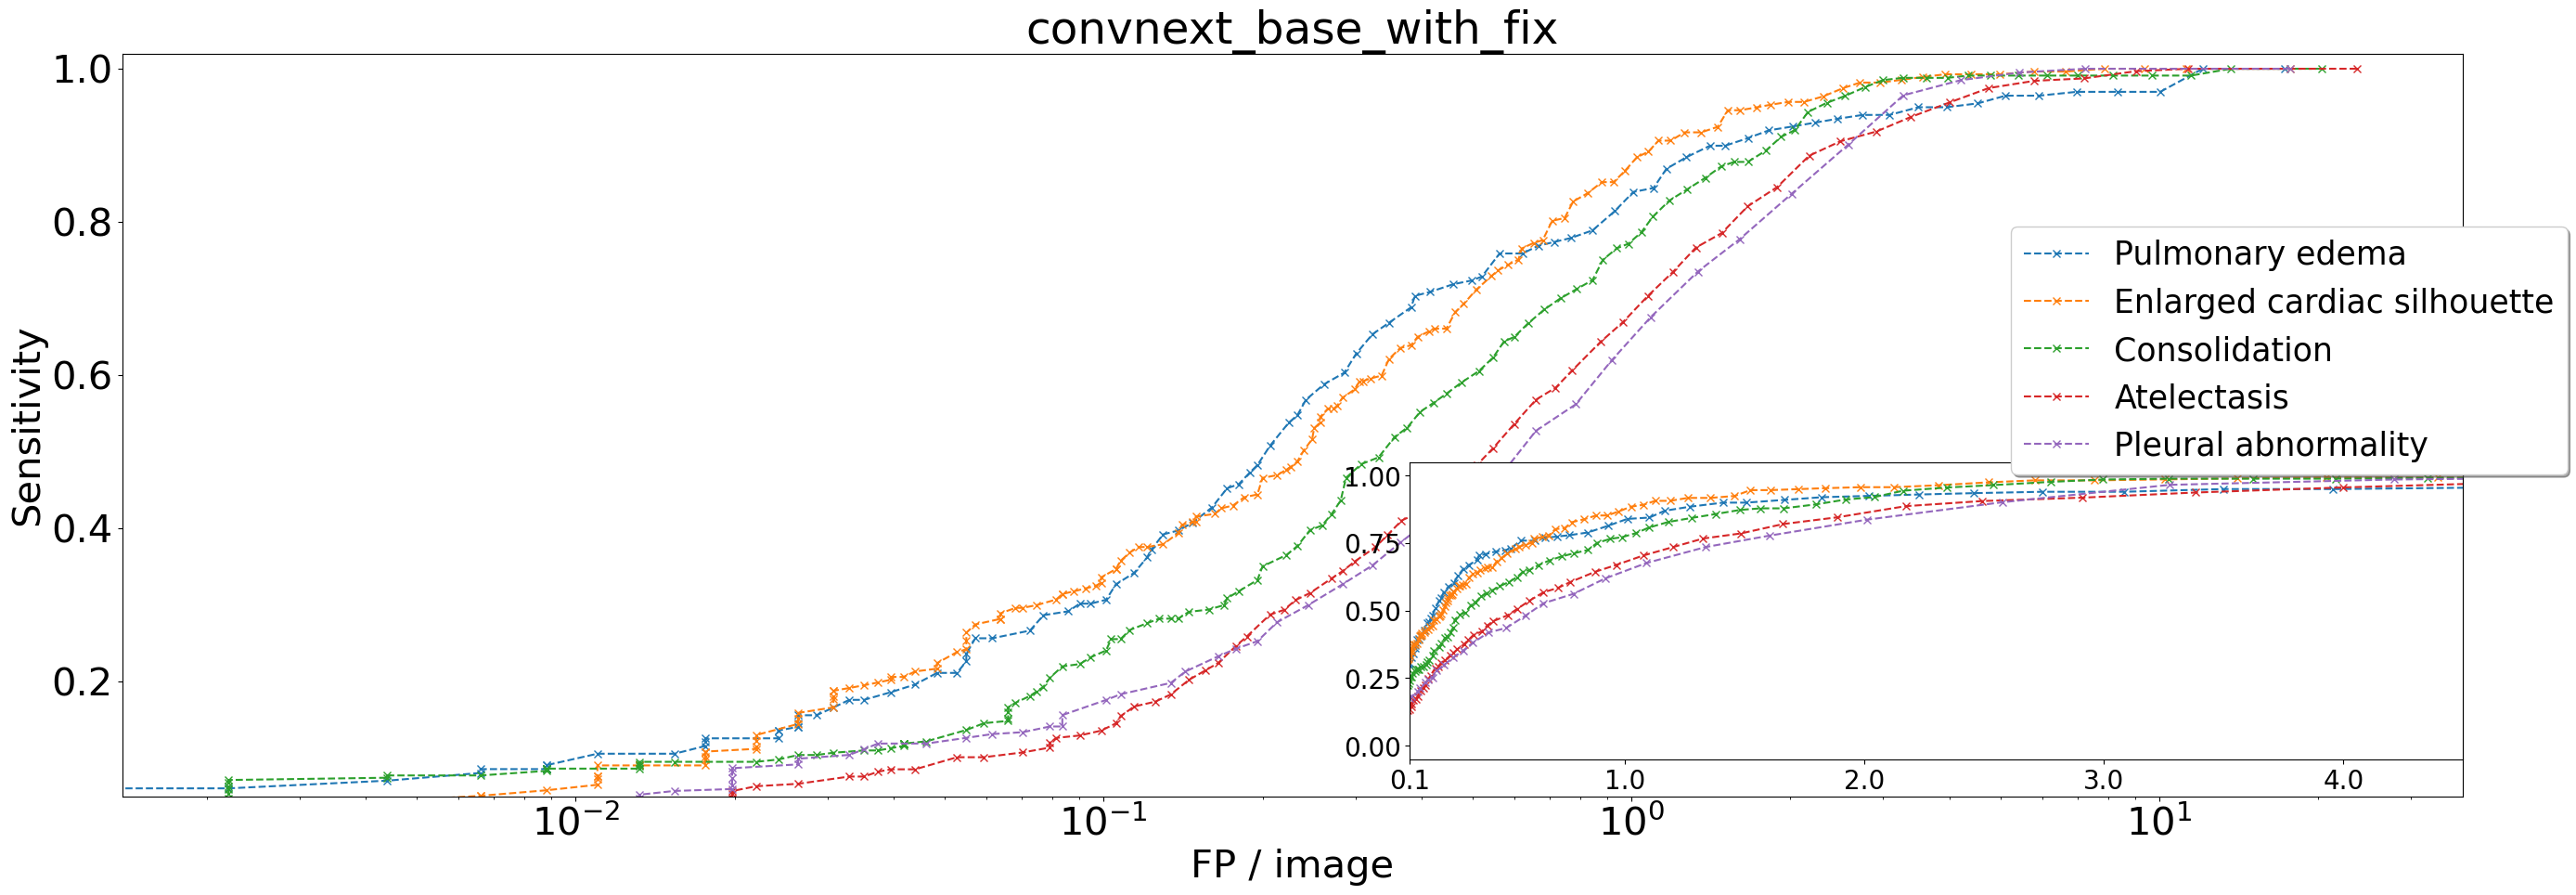

In [7]:
# just generate for the test set.
for select_model in tqdm(list([TrainedModels.convnext_base_with_fix])):
    clear_output()
    for score_thrs in score_thresholds:

        device = clean_memory_get_device()
        reproducibility()

        model, train_info, _, _ = get_trained_model(
            select_model,
            device,
        )
        model = model.to(device)
        model.eval()

        setup = train_info.model_setup
        iou_types = get_iou_types(model, setup)

        dataset_params_dict = {
            "MIMIC_EYE_PATH": MIMIC_EYE_PATH,
            "labels_cols": setup.lesion_label_cols,
            "with_xrays_input": SourceStrs.XRAYS in setup.sources,
            "with_clincal_input": SourceStrs.CLINICAL in setup.sources,
            "with_fixations_input": SourceStrs.FIXATIONS in setup.sources,
            "fixations_mode_input": setup.fiaxtions_mode_input,
            "with_bboxes_label": TaskStrs.LESION_DETECTION in setup.tasks,
            "with_fixations_label": TaskStrs.FIXATION_GENERATION in setup.tasks,
            "fixations_mode_label": setup.fiaxtions_mode_label,
            "with_chexpert_label": TaskStrs.CHEXPERT_CLASSIFICATION in setup.tasks,
            "with_negbio_label": TaskStrs.NEGBIO_CLASSIFICATION in setup.tasks,
            "clinical_numerical_cols": setup.clinical_num,
            "clinical_categorical_cols": setup.clinical_cat,
            "image_size": setup.image_size,
            "image_mean": setup.image_mean,
            "image_std": setup.image_std,
        }

        detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
            dataset_params_dict=dataset_params_dict,
        )

        train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
            train_dataset,
            val_dataset,
            test_dataset,
            batch_size=setup.batch_size,
        )

        train_coco = None
        train_coco, val_coco, test_coco, _ = get_coco_eval_params(
            source_name=SourceStrs.XRAYS,
            task_name=TaskStrs.LESION_DETECTION,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            detect_eval_dataset=detect_eval_dataset,
            iou_thrs=np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]),
            use_iobb=setup.use_iobb,
            maxDets=[1, 5, 10, 30],
        )

        normal_range_eval_params_dict = get_eval_params_dict(
            detect_eval_dataset,
            iou_thrs=normal_iou_thrs,
        )

        model.task_performers["lesion-detection"].roi_heads.score_thresh = 0
        test_evaluator, _ = evaluate(
            setup=setup,
            model=model,
            data_loader=test_dataloader,
            device=device,
            params_dict=normal_range_eval_params_dict,
            coco=test_coco,
            iou_types=iou_types,
            return_dt_gt=True,
        )
        model.task_performers["lesion-detection"].roi_heads.score_thresh = 0.05

        stats, lls_accuracy, nlls_per_image = get_froc_curve(
            dataset=test_dataset,
            dts=test_evaluator.all_dts,
            all_gts=test_evaluator.all_gts,
            plot_title= naming_map[select_model],
            use_iou=True,
            n_sample_points=200,
            froc_save_folder="./froc_figures"
        )

        all_cat_ids = [None] + [
            detect_eval_dataset.disease_to_idx(d)
            for d in detect_eval_dataset.labels_cols
        ]

        for cat_id in all_cat_ids:
            cat_ids = (
                [
                    detect_eval_dataset.disease_to_idx(d)
                    for d in detect_eval_dataset.labels_cols
                ]
                if cat_id is None
                else [cat_id]
            )

            if not (cat_ids is None):
                normal_range_eval_params_dict["bbox"].catIds = cat_ids

            test_evaluator, _ = evaluate(
                setup=setup,
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=normal_range_eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
            )

            if cat_id is None:
                disease_str = "all"
            else:
                disease_str = detect_eval_dataset.label_idx_to_disease(cat_id)

            froc_v = get_interpolate_froc(
                stats=stats,
                lls_accuracy=lls_accuracy,
                nlls_per_image=nlls_per_image,
                cat_id=cat_id,
                fps_per_img=[0.5, 1, 2, 4],
                weight=True,
            )

            df = pd.DataFrame(
                [
                    {
                        "num_fps": test_evaluator["lesion-detection"]
                        .coco_eval["bbox"]
                        .eval["num_fps"],  # @all_range, maxDet= p.maxDets[-1]
                        "num_fns": test_evaluator["lesion-detection"]
                        .coco_eval["bbox"]
                        .eval["num_fns"],
                        "num_tps": test_evaluator["lesion-detection"]
                        .coco_eval["bbox"]
                        .eval["num_tps"],
                        "coco_states": json.dumps(
                            test_evaluator["lesion-detection"].coco_eval["bbox"].stats
                        ),
                        "Sensitivity@ [avgFP=0.5]": froc_v[0],
                        "Sensitivity@ [avgFP=1]": froc_v[1],
                        "Sensitivity@ [avgFP=2]": froc_v[2],
                        "Sensitivity@ [avgFP=4]": froc_v[3],
                        "mFROC@[0.5,1,2,4]": froc_v.mean(),
                    },
                ]
            )

            df.to_csv(
                os.path.join(
                    "./eval_results",
                    f"{select_model.value}_{disease_str}_{score_thrs}.csv",
                )
            )

            print_title(f"{select_model.value}-{disease_str}")
            print(df)
